<a href="https://colab.research.google.com/github/Chenyuju/chen/blob/master/Copy_of_Classification(Heart_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import OneVsRest

In [153]:
import findspark
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

visualization = pd.read_csv('/content/chen/vheart.csv')
visualization.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'target']

heart_data = spark.read.format('com.databricks.spark.csv').\
                              options(header='true', \
                              inferschema='true') \
                .load("/content/chen/heart.csv",header=True);

heart_data.show(10)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|
| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    2|  0|   3|

In [167]:
def transData(data):
  return data.rdd.map(lambda r: [Vectors.dense(r[:-2]),r[12]]).toDF(['features','label'])

transformed = transData(heart_data)
trainingData, testData = transformed.randomSplit([0.7, 0.3])

transformed.sample(False, 0.1, 123).show(10)

heart_data.count(),trainingData.count(),testData.count()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[51.0,1.0,0.0,140...|    3|
|[50.0,1.0,2.0,129...|    2|
|[41.0,1.0,1.0,135...|    1|
|[29.0,1.0,1.0,130...|    2|
|[37.0,0.0,2.0,120...|    2|
|[58.0,1.0,2.0,140...|    2|
|[62.0,0.0,0.0,140...|    2|
|[43.0,0.0,2.0,122...|    2|
|[62.0,1.0,1.0,120...|    3|
|[64.0,0.0,0.0,180...|    2|
+--------------------+-----+
only showing top 10 rows



(1025, 712, 313)

In [0]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(transformed)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(transformed)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

evaluator_lr_ovr = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

In [0]:
lr = LogisticRegression()

model_lr = lr.fit(trainingData)
predictions_lr = model_lr.transform(testData)

accuracy_lr = evaluator_lr_ovr.evaluate(predictions_lr)

In [0]:
ovr = OneVsRest(classifier=lr)

model_ovr= ovr.fit(trainingData)
predictions_ovr = model_ovr.transform(testData)

accuracy_ovr = evaluator_lr_ovr.evaluate(predictions_ovr)

In [0]:
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline_dt = Pipeline(stages=[labelIndexer, featureIndexer, dt])
model_dt = pipeline_dt.fit(trainingData)
predictions_dt = model_dt.transform(testData)

accuracy_dt = evaluator.evaluate(predictions_dt)
treeModel = model_dt.stages[2]

In [0]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=30)

pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model_rf = pipeline_rf.fit(trainingData)

predictions_rf = model_rf.transform(testData)

accuracy_rf = evaluator.evaluate(predictions_rf)
rfModel = model_rf.stages[2]

In [0]:
nb = NaiveBayes(smoothing=1.0, labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline_nb = Pipeline(stages=[labelIndexer, featureIndexer, nb, labelConverter])
model_nb = pipeline_nb.fit(trainingData)
predictions_nb = model_nb.transform(testData)

accuracy_nb = evaluator.evaluate(predictions_nb)

In [0]:
layers = [12, 20, 15, 10, 5, 4]

mlp = MultilayerPerceptronClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=100, layers=layers, blockSize=128, seed=1234)

pipeline_mlp = Pipeline(stages=[labelIndexer, featureIndexer, mlp, labelConverter])
model_mlp = pipeline_mlp.fit(trainingData)
predictions_mlp = model_mlp.transform(testData)

accuracy_mlp = evaluator.evaluate(predictions_mlp)

In [176]:
print("Test Error of Logistic Regression = %g \n" % (1.0 - accuracy_lr))

print("Test Error of One-Vs-Rest = %g \n" % (1.0 - accuracy_ovr))

print("Test Error of Decision Tree = %g" % (1.0 - accuracy_dt))

print(treeModel, "\n")

print("Test Error of Random Forest = %g" % (1.0 - accuracy_rf))
print(rfModel, "\n") 

print("Test Error of Naive Bayes = %g \n" % (1.0 - accuracy_nb))

print("Test Error of Multilayer-Perceptron = %g" % (1.0 - accuracy_mlp))

Test Error of Logistic Regression = 0.319489 

Test Error of One-Vs-Rest = 0.322684 

Test Error of Decision Tree = 0.27476
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_45a8df37c755) of depth 5 with 47 nodes 

Test Error of Random Forest = 0.220447
RandomForestClassificationModel (uid=RandomForestClassifier_83364bd2b7e9) with 30 trees 

Test Error of Naive Bayes = 0.408946 

Test Error of Multilayer-Perceptron = 0.42492


Accuracy :  68.051 %         72.524 %           77.955 %           59.105 %         57.508 %          67.732 %       


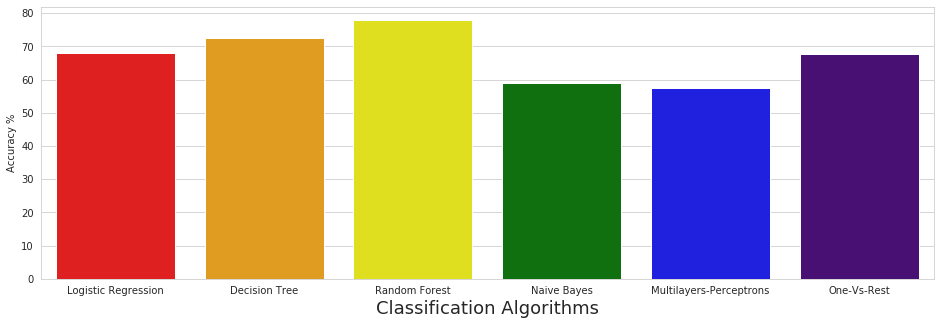

In [178]:
methods = ["Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes", "Multilayers-Perceptrons", "One-Vs-Rest"]
accuracy = [float("{0:.3f}".format(accuracy_lr*100)), float("{0:.3f}".format(accuracy_dt*100)), float("{0:.3f}".format(accuracy_rf*100)), 
            float("{0:.3f}".format(accuracy_nb*100)), float("{0:.3f}".format(accuracy_mlp*100)), float("{0:.3f}".format(accuracy_ovr*100))]

colors = ["red", "orange", "yellow", "green", "blue", "indigo"]
sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))  
print("Accuracy : ", accuracy[0], "%        ", accuracy[1], "%          ", accuracy[2], "%          ", accuracy[3], "%        ",
     accuracy[4], "%         ", accuracy[5], "%       ")
plt.ylabel("Accuracy %")
plt.xlabel("Classification Algorithms", fontsize=18)
sns.barplot(x=methods, y=accuracy, palette=colors)
plt.show()

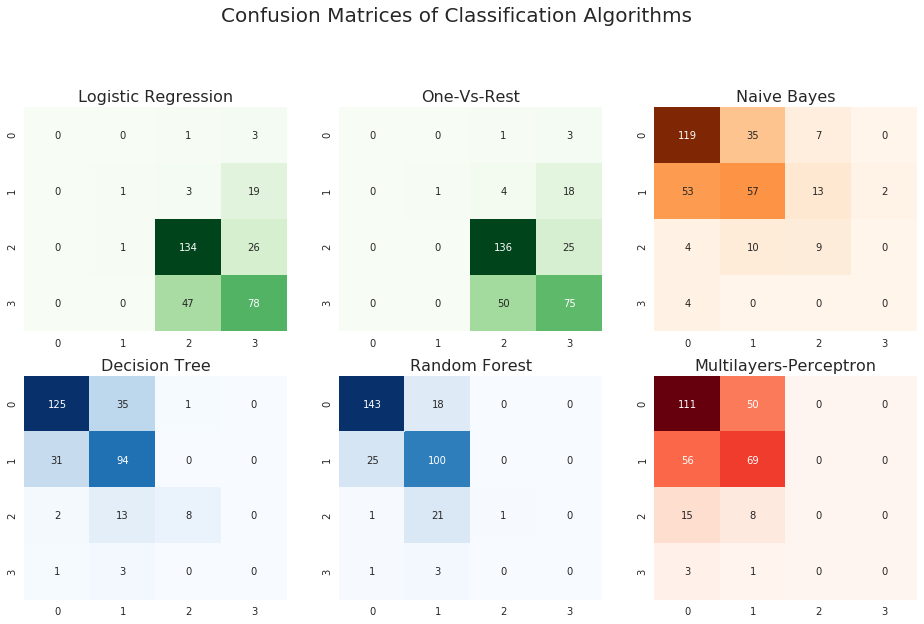

In [179]:
from sklearn.metrics import confusion_matrix

y_true_lr = predictions_lr.select("label").toPandas()
y_pred_lr = predictions_lr.select("prediction").toPandas()
c_m_lr = confusion_matrix(y_true_lr, y_pred_lr)


y_true_nb = predictions_nb.select("indexedLabel").toPandas()
y_pred_nb = predictions_nb.select("prediction").toPandas()
c_m_nb = confusion_matrix(y_true_nb, y_pred_nb)


y_true_mlp = predictions_mlp.select("indexedLabel").toPandas()
y_pred_mlp = predictions_mlp.select("prediction").toPandas()
c_m_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)


y_true_dt = predictions_dt.select("indexedLabel").toPandas()
y_pred_dt = predictions_dt.select("prediction").toPandas()
c_m_dt = confusion_matrix(y_true_dt, y_pred_dt)


y_true_rf = predictions_rf.select("indexedLabel").toPandas()
y_pred_rf = predictions_rf.select("prediction").toPandas()
c_m_rf = confusion_matrix(y_true_rf, y_pred_rf)

'''
y_true_gbt = predictions_gbt.select("indexedLabel").toPandas()
y_pred_gbt = predictions_gbt.select("prediction").toPandas()
c_m_gbt = confusion_matrix(y_true_gbt, y_pred_gbt)

'''
y_true_ovr = predictions_ovr.select("label").toPandas()
y_pred_ovr = predictions_ovr.select("prediction").toPandas()
c_m_ovr = confusion_matrix(y_true_ovr, y_pred_ovr)

plt.figure(figsize=(16,14))
plt.suptitle("Confusion Matrices of Classification Algorithms", fontsize = 20)

plt.subplot(3,3,1)
plt.title("Logistic Regression", fontsize = 16)
sns.heatmap(c_m_lr,annot=True,cmap="Greens",fmt="d",cbar=False)


plt.subplot(3,3,2)
plt.title("One-Vs-Rest", fontsize = 16)
sns.heatmap(c_m_ovr,annot=True,cmap="Greens",fmt="d",cbar=False)

plt.subplot(3,3,3)
plt.title("Naive Bayes", fontsize = 16)
sns.heatmap(c_m_nb,annot=True,cmap="Oranges",fmt="d",cbar=False)

plt.subplot(3,3,4)
plt.title("Decision Tree", fontsize = 16)
sns.heatmap(c_m_dt,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,3,5)
plt.title("Random Forest", fontsize = 16)
sns.heatmap(c_m_rf,annot=True,cmap="Blues",fmt="d",cbar=False)

'''
plt.subplot(3,3,6)
plt.title("Gradient-Boosted", fontsize = 16)
sns.heatmap(c_m_ovr,annot=True,cmap="Blues",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)
'''
plt.subplot(3,3,6)
plt.title("Multilayers-Perceptron", fontsize = 16)
sns.heatmap(c_m_mlp,annot=True,cmap="Reds",fmt="d",cbar=False)

plt.show()